In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

import numpy as np

from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua import QuantumInstance
from qiskit.providers.aer.noise import thermal_relaxation_error, ReadoutError, depolarizing_error

provider = IBMQ.get_provider(hub='ibm-q')
machine = provider.get_backend('ibmq_armonk')
# from qiskit.test.mock import FakeLondon
# machine = FakeLondon()
# machine_noise_model = NoiseModel.from_backend(machine)
simulator = Aer.get_backend('qasm_simulator')


C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


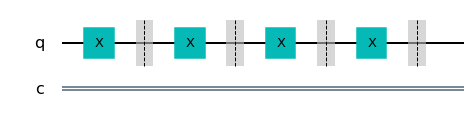

In [10]:
circ = QuantumCircuit(1,1)
circ.x(0)
circ.barrier(0)
circ.x(0)
circ.barrier(0)
circ.x(0)
circ.barrier(0)
circ.x(0)
circ.barrier(0)
circ.draw(output = 'mpl')

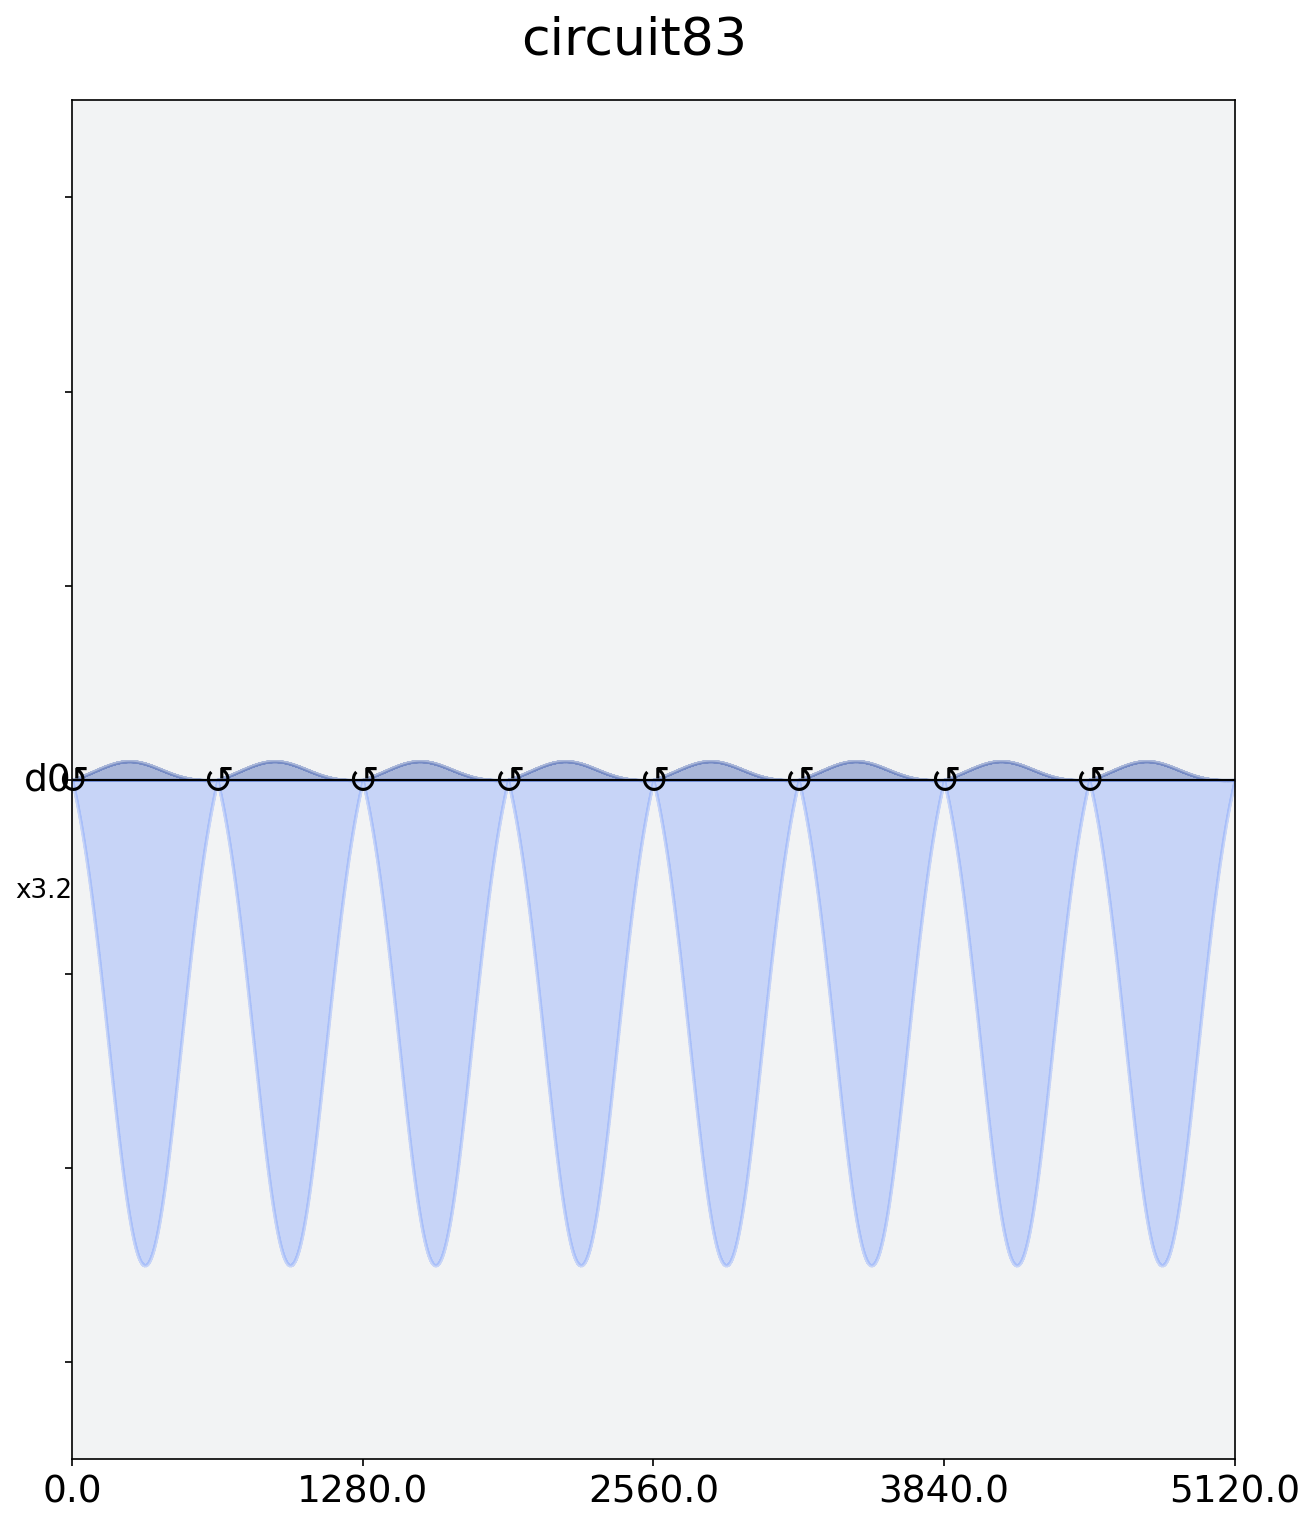

In [11]:
from qiskit.compiler import schedule 
from qiskit.compiler import transpile

circ_device = transpile(circ, machine)
sched_circ = schedule(circ_device, machine)
sched_circ.draw()

In [12]:
sched_circ.instructions

((0, ShiftPhase(-3.141592653589793, DriveChannel(0))),
 (0,
  Play(Drag(duration=640, amp=(0.31343560574267093-0.010594497127116609j), sigma=160, beta=-3.462735749870098), DriveChannel(0))),
 (640, ShiftPhase(-3.141592653589793, DriveChannel(0))),
 (640,
  Play(Drag(duration=640, amp=(-0.31343560574267093+0.010594497127116666j), sigma=160, beta=-3.462735749870098), DriveChannel(0))),
 (1280, ShiftPhase(-0.0, DriveChannel(0))),
 (1280, ShiftPhase(-3.141592653589793, DriveChannel(0))),
 (1280,
  Play(Drag(duration=640, amp=(0.31343560574267093-0.010594497127116609j), sigma=160, beta=-3.462735749870098), DriveChannel(0))),
 (1920, ShiftPhase(-3.141592653589793, DriveChannel(0))),
 (1920,
  Play(Drag(duration=640, amp=(-0.31343560574267093+0.010594497127116666j), sigma=160, beta=-3.462735749870098), DriveChannel(0))),
 (2560, ShiftPhase(-0.0, DriveChannel(0))),
 (2560, ShiftPhase(-3.141592653589793, DriveChannel(0))),
 (2560,
  Play(Drag(duration=640, amp=(0.31343560574267093-0.01059449712

In [13]:
import numpy as np
c = 2
e = np.log(c)*2*(160**2)
d = 640 

coeff = [1, -2*d, 4*e +d**2]
np.roots(coeff)

array([640.+376.7712072j, 640.-376.7712072j])

In [33]:
from qiskit.scheduler import measure
from qiskit.pulse.instructions import Play
from qiskit import pulse
from qiskit.pulse import Drag


def stretchSchedule(sched, factor):
    # args:circuit in pulse form WITHOUT measurement, stretch factor
    #output: pulses stretched by thefactor
    
    instrucs = sched.instructions
    new_sched = pulse.Schedule(name = "Schedule stretched by factor " + str(factor))
    
    #Only stretching the sample pulse, doing nothing to shiftphase, measurement,etc.
    
    for instruc_paren in instrucs:
        instruc = instruc_paren[1]
        #if drag/gaussian square
        if (isinstance(instruc, Play)):
            
            #print(instruc)
            
            if (isinstance(instruc.pulse, Drag)):
                drag = instruc.pulse
                ## param = {"duration": self.duration, "amp": self.amp, "sigma": self.sigma, "width": self.width}
                param = drag.parameters
                print("Initial Param")
                print(param)
                print("final Param")
                print('Duration' + str(factor*param['duration']))

                #stretching the drag pulse
                s_pulse = Drag(int(factor*param['duration']), param['amp']/factor, factor*param['sigma'], param['beta'])
                channel = instruc.channels[0]
                new_sched+= pulse.Play(s_pulse, channel)
        #otherwise
            else: 
                new_sched+= instruc
        else:
            new_sched+= instruc
    
    #adding measurement
    new_sched +=measure([0], machine) <<new_sched.duration   #([0], backend)
    return new_sched

In [34]:
#now making the scaled schedule
scaled_schedules = []
scales = [1, 1.1, 1.2, 1.3, 1.4, 1.5]


for i in scales:
    scaled_schedules.append(stretchSchedule(sched_circ, i))

Initial Param
{'duration': 640, 'amp': (0.31343560574267093-0.010594497127116609j), 'sigma': 160, 'beta': -3.462735749870098}
final Param
Duration640
Initial Param
{'duration': 640, 'amp': (-0.31343560574267093+0.010594497127116666j), 'sigma': 160, 'beta': -3.462735749870098}
final Param
Duration640
Initial Param
{'duration': 640, 'amp': (0.31343560574267093-0.010594497127116609j), 'sigma': 160, 'beta': -3.462735749870098}
final Param
Duration640
Initial Param
{'duration': 640, 'amp': (-0.31343560574267093+0.010594497127116666j), 'sigma': 160, 'beta': -3.462735749870098}
final Param
Duration640
Initial Param
{'duration': 640, 'amp': (0.31343560574267093-0.010594497127116609j), 'sigma': 160, 'beta': -3.462735749870098}
final Param
Duration640
Initial Param
{'duration': 640, 'amp': (-0.31343560574267093+0.010594497127116666j), 'sigma': 160, 'beta': -3.462735749870098}
final Param
Duration640
Initial Param
{'duration': 640, 'amp': (0.31343560574267093-0.010594497127116609j), 'sigma': 160,

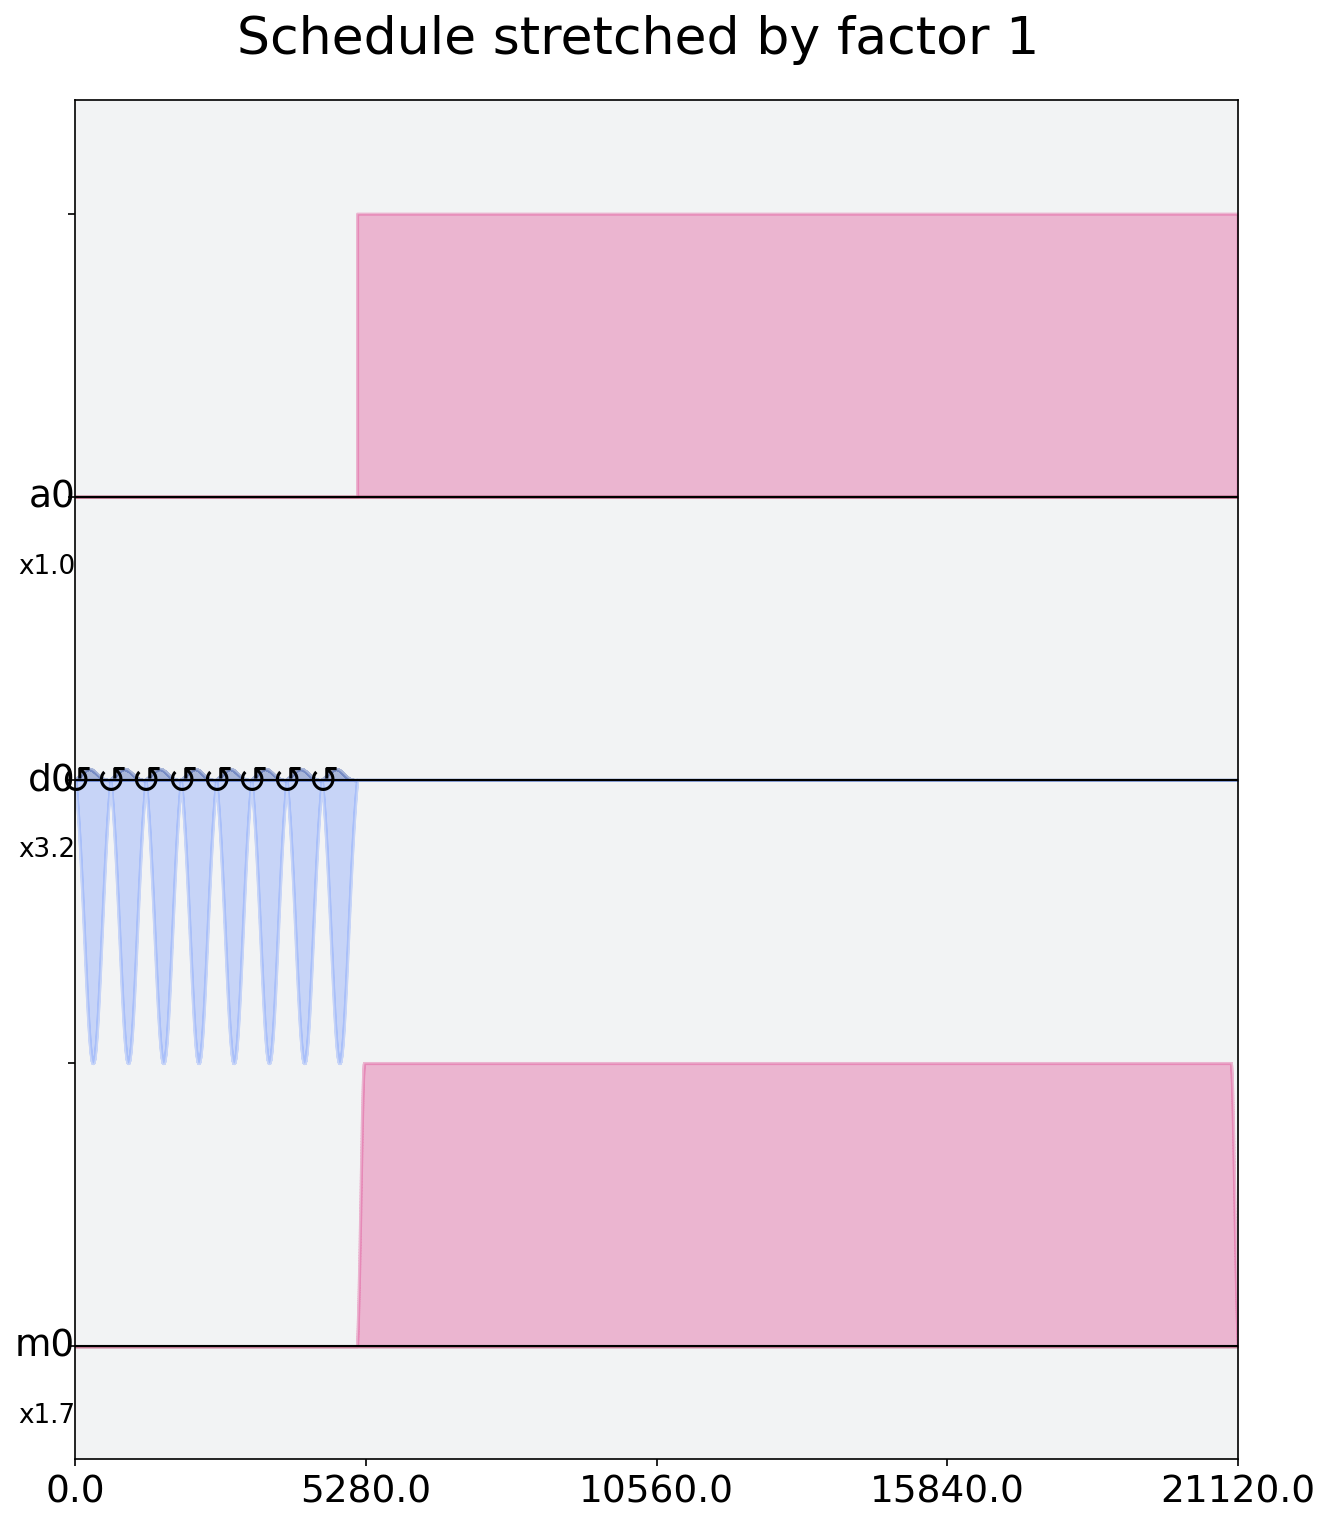

In [35]:
scaled_schedules[0].draw()

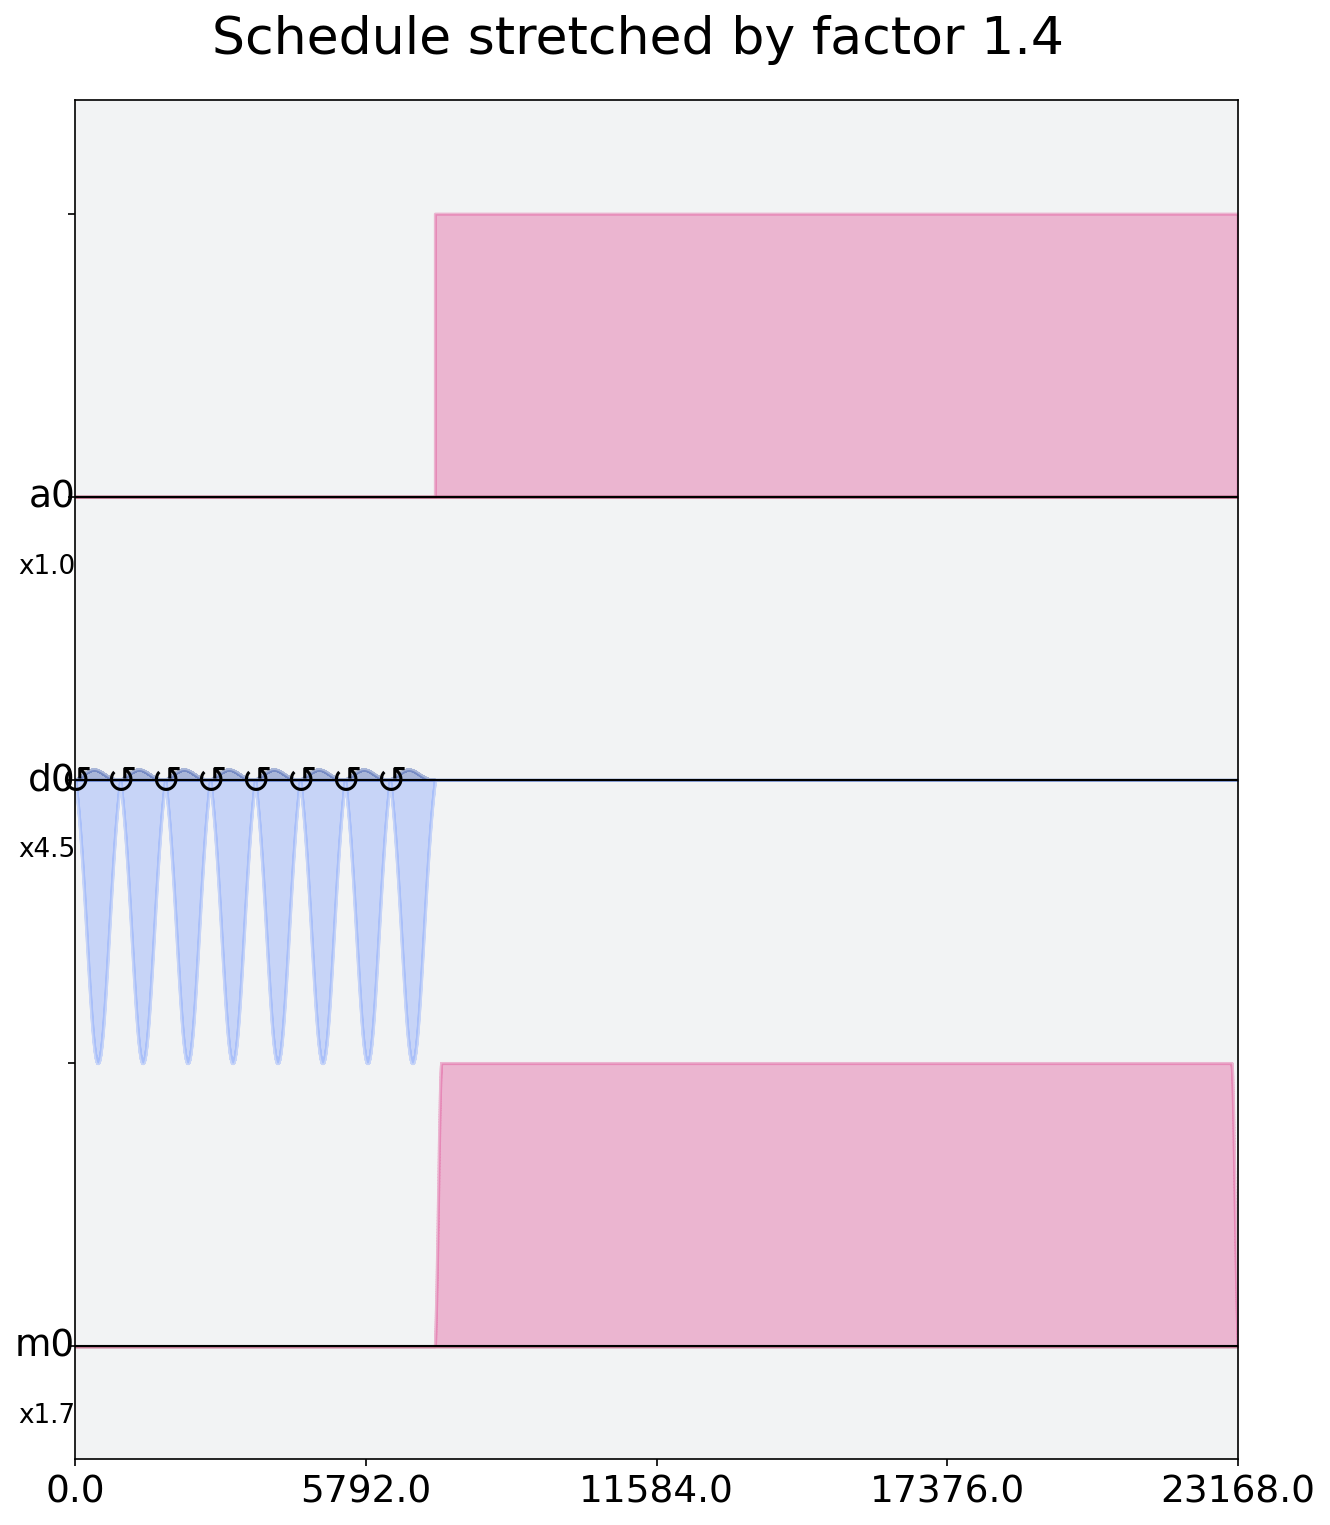

In [36]:
scaled_schedules[4].draw()

## Running the Schedules

### On Simulator

In [37]:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel

# Mock Armonk backend
from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk

armonk_backend = FakeArmonk()

# set the drive strength
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = 63455017.85

# set the qubit frequency
freq_est = 4.97e9
armonk_backend.defaults().qubit_freq_est = [freq_est]
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = 2*np.pi*freq_est

armonk_model = PulseSystemModel.from_backend(armonk_backend)

In [41]:
backend_sim = PulseSimulator()
obj = assemble(scaled_schedules,
                     backend=backend_sim,
                     meas_level=1,
                     meas_return='avg',
                     shots=512)

sim_result = backend_sim.run(obj, armonk_model, meas_level = 2).result()

C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\qiskit\pulse\library\parametric_pulses.py:78: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  ' Use `get_waveform` instead.', DeprecationWarning)
C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\qiskit\pulse\library\parametric_pulses.py:78: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  ' Use `get_waveform` instead.', DeprecationWarning)
C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\qiskit\pulse\library\parametric_pulses.py:78: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  ' Use `get_waveform` instead.', DeprecationWarning)
C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\qiskit\pulse\library\parametric_pulses.py:78: DeprecationWarning: `get_sample_pulse` has been deprecated.  Use `get_waveform` instead.
  ' Use `get_waveform` instead.', DeprecationWarning)
C:\Users\Eesh Gupta\anacondaaa\lib\site-packages

TypeError: run() got an unexpected keyword argument 'meas_level'

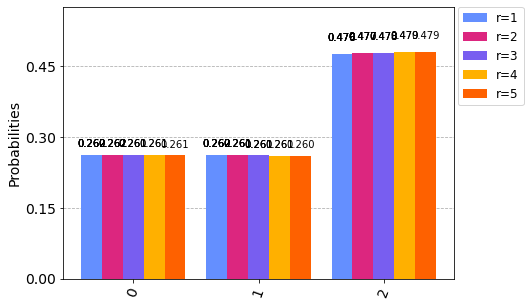

In [39]:

from qiskit.visualization import plot_histogram
results=[]
for i in range(5): 
    results.append(sim_result.get_counts(i))
plot_histogram(results, legend = ['r=1', 'r=2', 'r=3', 'r=4', 'r=5'])


#job = execute(scaled_schedules, backend, shots = 2048, meas_level=2 )

### On Armonk

In [42]:
from qiskit.tools.monitor import job_monitor

job = execute(scaled_schedules, machine, shots = 2048, meas_level=2 )
job_monitor(job)

Job Status: job has successfully run


In [43]:
result = job.result()
result

In [44]:
result.get_counts()

[{'0': 1972, '1': 76},
 {'0': 1988, '1': 60},
 {'0': 1980, '1': 68},
 {'0': 1984, '1': 64},
 {'0': 1958, '1': 90},
 {'0': 1971, '1': 77}]